# Programming and Database Fundamentals for Data Scientists - EAS503

## Basic introduction to `Scikit-Learn`
`scikit-learn` or `sklearn` is a `Python` machine learning library.

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt
from helper import *
import numpy as np
import warnings

In [36]:
 warnings.filterwarnings("ignore")

### Outline

* Classification
* Model evaluation and selection
* Transformers, pipelines and feature unions
* Beyond building classifiers


## Classification
Data comes as a finite learning set ${\cal L} = (X, y)$ where
* Input samples are given as an array $X$ of shape `n_samples` $\times$ `n_features`, taking their values in ${\cal X}$;
* Output values are given as an array $y$, taking _symbolic_ values in ${\cal Y}$.

The goal of supervised classification is to build an estimator $\varphi: {\cal X} \mapsto {\cal Y}$ minimizing

$$
Err(\varphi) = \mathbb{E}_{X,Y}\{ \ell(Y, \varphi(X)) \}
$$

where $\ell$ is a loss function, e.g., the zero-one loss for classification $\ell_{01}(Y,\hat{Y}) = 1(Y \neq \hat{Y})$.

## Data 

- Input data = Numpy arrays or Scipy sparse matrices ;
- Algorithms are expressed using high-level operations defined on matrices or vectors (similar to MATLAB) ;
    - Leverage efficient low-leverage implementations ;
    - Keep code short and readable. 

In [80]:
# Generate data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=123)
labels = ["b", "r"]
y = np.take(labels, (y < 10))
print(X) 
print(y[:5])

[[-6.45255647 -8.76358259]
 [ 0.28982141  0.14677196]
 [-5.18412293 -1.25347025]
 ...
 [-0.23142814 -1.60800704]
 [-0.60291835  6.87297279]
 [ 2.28425964  4.87408773]]
['r' 'r' 'b' 'r' 'b']


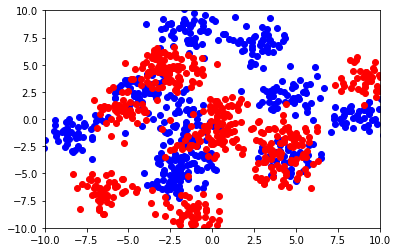

In [81]:
# Plot
plt.figure()
for label in labels:
    mask = (y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=label)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

## A simple and unified API

All learning algorithms in scikit-learn share a uniform and limited API consisting of complementary interfaces:

- a `learn` interface for building and fitting models;
- a `predict` interface for making predictions;
- a `transform` interface for converting data.

Goal: enforce a simple and consistent API to __make it trivial to swap or plug algorithms__. 

#### Creating the model

In [51]:
# Import the nearest neighbor class
from sklearn.neighbors import KNeighborsClassifier  # Change this to try 
                                                    # something else
# Set hyper-parameters, for controlling algorithm
clf = KNeighborsClassifier(n_neighbors=5)

#### Learn a model from training data

In [64]:
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [59]:
clf._tree

#### Predicting

In [65]:
print(clf.predict(X[:5])) 

['r' 'r' 'r' 'b' 'r']


In [66]:
print(clf.predict_proba(X[:5]))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


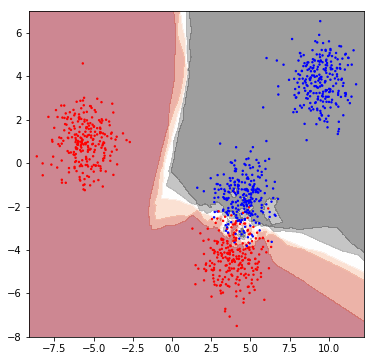

In [67]:
plot_surface(clf,X,y)

### Exploring classifiers

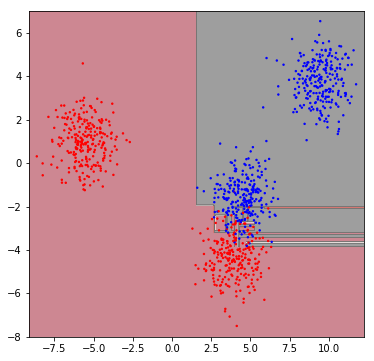

In [68]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier()
clf.fit(X, y)
plot_surface(clf, X, y)

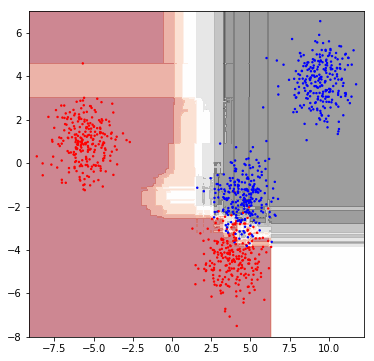

In [69]:
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y)
plot_surface(clf, X, y)

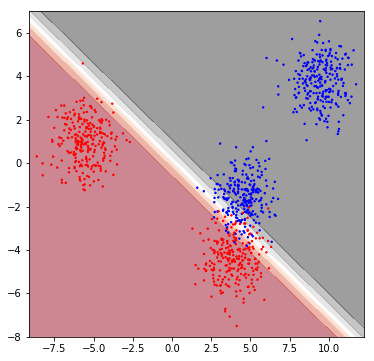

In [70]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y)
plot_surface(clf, X, y)

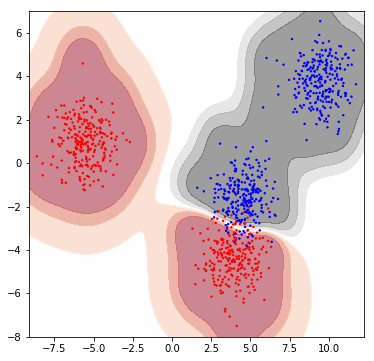

In [72]:
from sklearn.svm import SVC
clf = SVC(kernel="rbf",probability=True)
clf.fit(X, y)
plot_surface(clf, X, y)

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
clf = GaussianProcessClassifier()
clf.fit(X, y)
plot_surface(clf, X, y)         

## Model evaluation and selection
- Recall that we want to learn an estimator $\varphi$ minimizing the generalization error $Err(\varphi) = \mathbb{E}_{X,Y}\{ \ell(Y, \varphi(X)) \}$.

- Problem: Since $P_{X,Y}$ is unknown, the generalization error $Err(\varphi)$ cannot be evaluated.

- Solution: Use a proxy to approximate $Err(\varphi)$.

### Train Error

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)
print("Training error =", zero_one_loss(y, clf.predict(X)))

Training error = 0.0


### Test Error

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print("Training error =", zero_one_loss(y_train, clf.predict(X_train)))
print("Test error =", zero_one_loss(y_test, clf.predict(X_test)))

Training error = 0.0
Test error = 0.03600000000000003


### Cross-validation
Issue: 
- When ${\cal L}$ is small, training on 70% of the data may lead to a model that is significantly different from a model that would have been learned on the entire set ${\cal L}$. 
- Yet, increasing the size of the training set (resp. decreasing the size of the test set), might lead to an inaccurate estimate of the generalization error. 

Solution: K-Fold cross-validation. 
- Split ${\cal L}$ into K small disjoint folds. 
- Train on K-1 folds, evaluate the test error one the held-out fold.
- Repeat for all combinations and average the K estimates of the generalization error.


In [77]:
from sklearn.model_selection import KFold

scores = []

for train, test in KFold(n_splits=5, random_state=42).split(X):
    X_train, y_train = X[train], y[train]
    X_test, y_test = X[test], y[test]
    clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
    scores.append(zero_one_loss(y_test, clf.predict(X_test)))

print("CV error = %f +-%f" % (np.mean(scores), np.std(scores)))

CV error = 0.046000 +-0.010198


In [78]:
# Shortcut
from sklearn.model_selection import cross_val_score
scores = cross_val_score(KNeighborsClassifier(n_neighbors=5), X, y, 
                         cv=KFold(n_splits=5, random_state=42), 
                         scoring="accuracy")
print("CV error = %f +-%f" % (1. - np.mean(scores), np.std(scores)))

CV error = 0.046000 +-0.010198


## Metrics

### Default score

Estimators come with a built-in default evaluation score
* Accuracy for classification 
* R2 score for regression

In [10]:
y_train = (y_train == "r")
y_test = (y_test == "r")
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train) 
print("Default score =", clf.score(X_test, y_test))

Default score = 0.84


### Accuracy

Definition: The accuracy is the proportion of correct predictions.

In [11]:
from sklearn.metrics import accuracy_score
print("Accuracy =", accuracy_score(y_test, clf.predict(X_test)))

Accuracy = 0.84


### Precision, recall and F-measure

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$
$$F = \frac{2 * Precision * Recall}{Precision + Recall}$$

In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
print("Precision =", precision_score(y_test, clf.predict(X_test)))
print("Recall =", recall_score(y_test, clf.predict(X_test)))
print("F =", fbeta_score(y_test, clf.predict(X_test), beta=1))

Precision = 0.8118811881188119
Recall = 0.8631578947368421
F = 0.8367346938775511


### ROC AUC

Definition: Area under the curve of the false positive rate (FPR) against the true positive rate (TPR) as the decision threshold of the classifier is varied.

ROC AUC = 0.9297744360902256


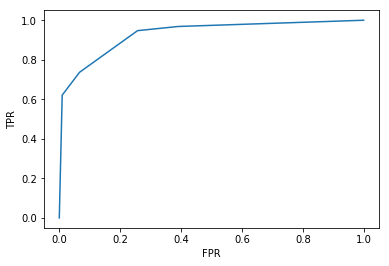

In [14]:
from sklearn.metrics import get_scorer
roc_auc_scorer = get_scorer("roc_auc")
print("ROC AUC =", roc_auc_scorer(clf, X_test, y_test))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Confusion matrix

Definition: number of samples of class $i$ predicted as class $j$.

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test))

array([[86, 19],
       [13, 82]])

### Model selection
 
- Finding good hyper-parameters is crucial to control under- and over-fitting, hence achieving better performance.
- The estimated generalization error can be used to select the best model.

### Under- and over-fitting

- Under-fitting: the model is too simple and does not capture the true relation between X and Y.
- Over-fitting: the model is too specific to the training set and does not generalize.

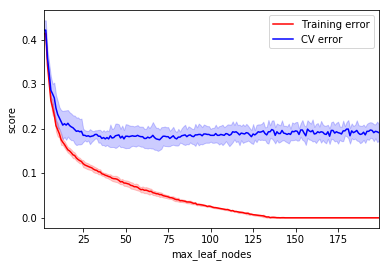

In [82]:
from sklearn.model_selection import validation_curve

# Evaluate parameter range in CV
param_range = range(2, 200)
param_name = "max_leaf_nodes"

train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), X, y, 
    param_name=param_name, 
    param_range=param_range, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot parameter VS estimated error
plt.xlabel(param_name)
plt.ylabel("score")
plt.xlim(min(param_range), max(param_range))
plt.plot(param_range, 1. - train_scores_mean, color="red", label="Training error")
plt.fill_between(param_range, 
                 1. - train_scores_mean + train_scores_std,
                 1. - train_scores_mean - train_scores_std,
                 alpha=0.2, color="red")
plt.plot(param_range, 1. - test_scores_mean, color="blue", label="CV error")
plt.fill_between(param_range, 
                 1. - test_scores_mean + test_scores_std,
                 1. - test_scores_mean - test_scores_std, 
                 alpha=0.2, color="blue")
plt.legend(loc="best")

In [83]:
# Best trade-off
print("%s = %d, CV error = %f" % (param_name,
                                  param_range[np.argmax(test_scores_mean)],
                                   1. - np.max(test_scores_mean)))

max_leaf_nodes = 70, CV error = 0.175000


### Hyper-parameter Search

In [20]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid={"n_neighbors": list(range(1, 100))},
                    scoring="accuracy",
                    cv=5, n_jobs=-1)
grid.fit(X, y)  # Note that GridSearchCV is itself an estimator

print("Best score = %f, Best parameters = %s" % (1. - grid.best_score_, 
                                                 grid.best_params_))

Best score = 0.131000, Best parameters = {'n_neighbors': 34}


## Transformers, pipelines and feature unions

### Transformers

- Classification (or regression) is often only one or the last step of a long and complicated process;
- In most cases, input data needs to be cleaned, massaged or extended before being fed to a learning algorithm;
- For this purpose, Scikit-Learn provides the ``transformer`` API.

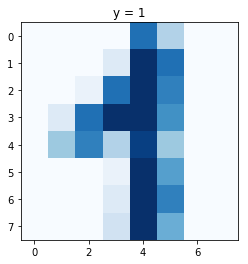

In [21]:
# Load digits data
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Plot
sample_id = 42
plt.imshow(X[sample_id].reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.title("y = %d" % y[sample_id])
plt.show()

#### Scalers and other normalizers


In [84]:
from sklearn.preprocessing import StandardScaler
tf = StandardScaler()
tf.fit(X_train, y_train)
Xt_train = tf.transform(X_train)  
print("Mean (before scaling) =", np.mean(X_train))
print("Mean (after scaling) =", np.mean(Xt_train))

# Shortcut: Xt = tf.fit_transform(X)
# See also Binarizer, MinMaxScaler, Normalizer, ...

Mean (before scaling) = 1.348094623535927
Mean (after scaling) = 8.881784197001253e-18


In [85]:
# Scaling is critical for some algorithms
from sklearn.svm import SVC
clf = SVC()
print("Without scaling =", clf.fit(X_train, y_train).score(X_test, y_test))
print("With scaling =", clf.fit(tf.transform(X_train), y_train).score(tf.transform(X_test), y_test))

Without scaling = 0.965
With scaling = 0.96


#### Feature selection

Shape = (1347, 10)


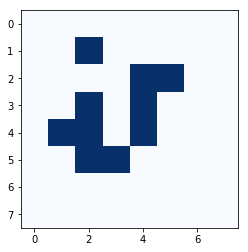

In [37]:
# Select the 10 top features, as ranked using ANOVA F-score
from sklearn.feature_selection import SelectKBest, f_classif
tf = SelectKBest(score_func=f_classif, k=10)
Xt = tf.fit_transform(X_train, y_train)
print("Shape =", Xt.shape)

# Plot support
plt.imshow(tf.get_support().reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.show()

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

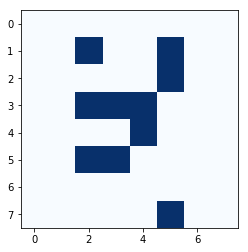

In [38]:
# Feature selection using backward elimination
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
tf = RFE(RandomForestClassifier(), n_features_to_select=10, verbose=1)
Xt = tf.fit_transform(X_train, y_train)
print("Shape =", Xt.shape)

# Plot support
plt.imshow(tf.get_support().reshape((8, 8)), interpolation="nearest", cmap=plt.cm.Blues)
plt.show()

#### Decomposition, factorization or embeddings

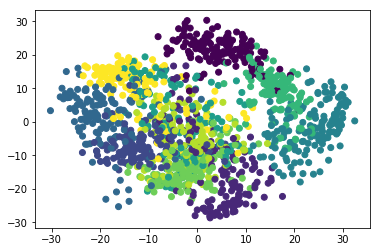

In [26]:
# Compute decomposition
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
tf = PCA(n_components=2)
Xt_train = tf.fit_transform(X_train)

# Plot
plt.scatter(Xt_train[:, 0], Xt_train[:, 1], c=y_train)
plt.show()

# See also: KernelPCA, NMF, FastICA, Kernel approximations, 
#           manifold learning, etc

### Pipelines

Transformers can be chained in sequence to form a pipeline.

In [86]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Chain transformers to build a new transformer
tf = make_pipeline(StandardScaler(), 
                   SelectKBest(score_func=f_classif, k=10))
tf.fit(X_train, y_train)

ValueError: k should be >=0, <= n_features; got 10.Use k='all' to return all features.

In [28]:
Xt_train = tf.transform(X_train)
print("Mean =", np.mean(Xt_train))
print("Shape =", Xt_train.shape)

Mean = -1.3715004550677509e-17
Shape = (1347, 10)


In [87]:
# Chain transformers + a classifier to build a new classifier
clf = make_pipeline(StandardScaler(), 
                    SelectKBest(score_func=f_classif, k=10), 
                    RandomForestClassifier())
clf.fit(X_train, y_train)
print(clf.predict_proba(X_test)[:5])

ValueError: k should be >=0, <= n_features; got 10.Use k='all' to return all features.

In [30]:
# Hyper-parameters can be accessed using step names
print("K =", clf.get_params()["selectkbest__k"])

K = 10


In [31]:
clf.named_steps

{'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'selectkbest': SelectKBest(k=10, score_func=<function f_classif at 0x11bbf78c8>),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [32]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(clf, 
                    param_grid={"selectkbest__k": [1, 10, 20, 30, 40, 50],
                                "randomforestclassifier__max_features": [0.1, 0.25, 0.5]})
grid.fit(X_train, y_train)

print("Best params =", grid.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39 56] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 24 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39 56] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 24 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/

Best params = {'randomforestclassifier__max_features': 0.1, 'selectkbest__k': 50}


/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 24 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 32 39] are constant.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


### Feature unions

Similarly, transformers can be applied in parallel to transform data in union.

### Nested composition

Since pipelines and unions are themselves estimators, they can be composed into nested structures.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_union
from sklearn.decomposition import PCA

clf = make_pipeline(
    # Build features
    make_union(
        PCA(n_components=3), # Identity
        PCA(),
    ), 
    # Select the best features
    RFE(RandomForestClassifier(), n_features_to_select=10),
    # Train
    MLPClassifier()
)

clf.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pca-1', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('pca-2', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver=...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [88]:
class Transformer(object):    
    def __init(self,targetindex):
        self.targetindex = targetindex
        
    def fit(self, X, y=None):
        """Fits estimator to data."""
        # set state of ``self``
        return self
    
    def transform(self, X):
        """Transform X into Xt."""
        # transform X in some way to produce Xt
        y = X
        return X,y
    
    # Shortcut
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        Xt = self.transform(X)
        return Xt